In [1]:
import sys
from os.path import isfile
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import random
import logging
from add_spikes import add_spikes
from shift_spectrum import shift_spectrum
from get_redshift import get_redshift
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [2]:
# -- Logging info
logging.basicConfig(filename='modifications.txt', level=logging.INFO,
                    format='%(asctime)s - %(message)s', filemode='w')

In [4]:
def modify(spectrum, sn_name, delay_phase):
    # --Error handling
    if not isinstance(spectrum, np.ndarray):
        raise TypeError(f"Error: Expected 'np.ndarray', got {type(spectrum).__name__}")
    if not isinstance(sn_name, str):
        raise TypeError(f"Error: Expected 'str', got {type(sn_name).__name__}")
    if not isinstance(delay_phase, float):
        raise TypeError(f"Error: Expected 'float', got {type(delay_phase).__name__}")

    # --Copy spectrum and log basic information
    modified_spectrum = spectrum.copy()
    logging.info(f'Object: {sn_name}, phase delay: {delay_phase}')

    # --Prepare modification details
    modification_details = {
        'Object': sn_name,
        'Phase Delay': delay_phase,
        'Modification Type': '',
        'Redshift Applied': False,
        'Spikes Added': False
    }

    # --Apply modifications
    modifications = random.randint(0, 3)
    if modifications == 0:
        logging.info('---Modifications: None')
        modification_details['Modification Type'] = 'None'
    else:
        try:
            redshift = get_redshift(sn_name)  # Intentar obtener el redshift
            modification_details['Redshift Applied'] = True
        except Exception as e:
            logging.warning(f"Warning: No se encontró redshift para {sn_name}. Detalle: {e}")
            redshift = 0.001  # Valor de redshift alternativo si no se encuentra el original
            logging.info(f'Usando redshift alternativo: {redshift}')

        if modifications == 1:
            logging.info('---Modifications: Shift spectra on x axis only')
            modified_spectrum = shift_spectrum(spectrum, redshift)
            modification_details['Modification Type'] = 'Shift Spectrum'
        elif modifications == 2:
            logging.info('---Modifications: Add spikes only')
            modified_spectrum = add_spikes(spectrum, redshift)
            modification_details['Modification Type'] = 'Add Spikes'
            modification_details['Spikes Added'] = True
        elif modifications == 3:
            logging.info('---Modifications: Shift spectra on x axis AND add spikes')
            modified_spectrum = add_spikes(shift_spectrum(spectrum, redshift), redshift)
            modification_details['Modification Type'] = 'Shift and Add Spikes'
            modification_details['Spikes Added'] = True

    # Convert details dictionary to a DataFrame
    modification_table = pd.DataFrame([modification_details])


    return modified_spectrum, modification_table

In [3]:
np.random.seed(3312)
url = "https://github.com/juanserrano90/codelatam/raw/main/Data/data/sn_data.parquet"
df_raw = pd.read_parquet(url)
wavelength = np.array([float(c) for c in df_raw.columns[5:]])
column_names = df_raw.columns.values.tolist()
column_names = np.array(column_names[5:]).astype(float)


In [6]:
data_aumentation_plan = pd.DataFrame(columns=['Type', 'N° of Copys'])

data_aumentation_plan['Type'] = ['IIP', 'IIn', 'Ic-pec', 'Ibn', 'Ib-pec','IIL']
data_aumentation_plan['N° of Copys'] = [41, 153 , 184, 186, 202, 204]

In [7]:
np.random.seed(1)
modified = []
modification_tables = pd.DataFrame()

for i in data_aumentation_plan['Type']:
    print(f"Procesando tipo: {i}")
    
    # Selecciona el subtipo a aumentar
    df_loc = df_raw[df_raw['SN Subtype'] == i]
    
    # Selecciona el número de copias necesarias
    n = data_aumentation_plan[data_aumentation_plan['Type'] == i]['N° of Copys'].values[0]

    # Contador para asegurar el número de copias por subtipo
    count = 0

    # Bucle para asegurar el número de copias deseado
    while count < n:
        # Selecciona una muestra
        df_loc_sampled = df_loc.sample(n=1, replace=True)
        
        # Aplica las modificaciones:
        for index, row in df_loc_sampled.iterrows():
            sn_name = index
            try:
                # Obtiene el valor de 'Spectral Phase'
                delay_phases = row['Spectral Phase']
                
                # Intenta obtener la muestra correspondiente de df_raw
                sample = df_raw.loc[(df_raw.index == sn_name)].iloc[:, 5:].values[0]

                # Modifica el espectro y guarda la tabla de modificaciones
                mod_spectrum, mod_table = modify(sample, sn_name, delay_phases)
                modified.append(mod_spectrum)
                modification_tables = pd.concat([modification_tables,mod_table])

                # Incrementa el contador solo si se genera una modificación
                count += 1

            except IndexError as e:
                print(f"Error: No se encontró un valor para la supernova {sn_name}. Detalle: {e}")
            except KeyError as e:
                print(f"Error: Columna no encontrada en la fila de {sn_name}. Detalle: {e}")
            except Exception as e:
                print(f"Error inesperado para {sn_name}. Detalle: {e}")




    

Procesando tipo: IIP
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010994369621877738
Wavelength shift: 6.872340659457863 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009793161454592053
Wavelength shift: 6.121491632872164 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009691121454086096
Wavelength shift: 6.057708654085207 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010871078141612063
Wavelength shift: 6.795273844175566 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010601489137351072
Wavelength shift: 6.626759637445709 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009823575757938105
Wavelength shift: 6.140502950546825 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009631031262012127
Wavelength shift: 6.0201475856085915 Å
Pixel shift: 0
Central wavelength: 6250.78189638

Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001059932238658746
Wavelength shift: 6.625405248800993 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009905706999903076
Wavelength shift: 6.1918413985870355 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010863722233273082
Wavelength shift: 6.790675826307891 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010148688448136
Wavelength shift: 6.3437238023641696 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010281810510574284
Wavelength shift: 6.426935500154011 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009454619472569378
Wavelength shift: 5.909876423632863 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009302312078695982
Wavelength shift: 5.814672393601949 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variatio

Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010684891619912827
Wavelength shift: 6.678892710256752 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009128860511159214
Wavelength shift: 5.706251601776138 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010249656273152987
Wavelength shift: 6.406836587637506 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010023194594011332
Wavelength shift: 6.265280331217187 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010468382878295833
Wavelength shift: 6.543557818005931 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010175743012592374
Wavelength shift: 6.360635020536012 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.000997043002106679
Wavelength shift: 6.232298347483972 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variati

Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010421479139799174
Wavelength shift: 6.514239314059171 Å
Pixel shift: 0
Procesando tipo: Ibn
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009480269810412298
Wavelength shift: 5.925909890375326 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.000925286178057937
Wavelength shift: 5.783762090778143 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009716645702365611
Wavelength shift: 6.073663304991646 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010784774977831437
Wavelength shift: 6.741327618799513 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010045271377640465
Wavelength shift: 6.279080047161122 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010566322036123202
Wavelength shift: 6.604777449475365 Å
Pixel shift: 0
Central wavelength: 6250.7818963831

Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001043317609358947
Wavelength shift: 6.521550824758691 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009858880599837483
Wavelength shift: 6.162571237206755 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010149879454555532
Wavelength shift: 6.344468274500738 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009827381472398203
Wavelength shift: 6.142881819651824 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009025045673772947
Wavelength shift: 5.641359211165134 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010846006081507331
Wavelength shift: 6.779601846234797 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009815978369053457
Wavelength shift: 6.13575398845683 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variatio

Central wavelength: 6250.781896383187 Å
Redshift variation: 0.001025688275957519
Wavelength shift: 6.411353706687742 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010476823741209214
Wavelength shift: 6.548834017314813 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010256678262029922
Wavelength shift: 6.411225879732361 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010752002384730145
Wavelength shift: 6.720842185634004 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009426494136975312
Wavelength shift: 5.8922958897767534 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009465830936767663
Wavelength shift: 5.916884465377121 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.000947571137448244
Wavelength shift: 5.923060511496708 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variati

Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010164430084278616
Wavelength shift: 6.35356355578614 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009572495585652371
Wavelength shift: 5.983558211000381 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009461113105457318
Wavelength shift: 5.913935451922632 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009388790041009446
Wavelength shift: 5.868727881728461 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009064105098068856
Wavelength shift: 5.665774405392336 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009497047693915716
Wavelength shift: 5.936397379421606 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010291766774835284
Wavelength shift: 6.4331589437938375 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variat

Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010154366758140631
Wavelength shift: 6.347273190102069 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009717486705596516
Wavelength shift: 6.074188997768699 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010766807303935544
Wavelength shift: 6.730096417728657 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009811548077088147
Wavelength shift: 6.132984709575585 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009957595387113504
Wavelength shift: 6.224275697727783 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0010663768704714412
Wavelength shift: 6.665689236664643 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variation: 0.0009830582983109165
Wavelength shift: 6.14488301417114 Å
Pixel shift: 0
Central wavelength: 6250.781896383187 Å
Redshift variati

In [21]:
modification_tables

,Object,Phase Delay,Modification Type,Redshift Applied,Spikes Added
0,sn1999em,119.0,Add Spikes,False,True
0,sn2005cs,0.1,Shift Spectrum,False,False
0,sn2005cs,13.8,Shift and Add Spikes,False,True
0,sn1999em,-3.6,Add Spikes,False,True
0,sn1992H,112.9,Shift and Add Spikes,False,True
...,...,...,...,...,...
0,sn1980K,66.0,Add Spikes,False,True
0,sn1980K,12.0,None,False,False
0,sn1980K,44.0,None,False,False
0,sn1979C,71.6,Shift and Add Spikes,False,True


In [22]:
modification_tables.to_csv('Modification_II.csv', index=False)

In [23]:
if isinstance(modified, list):
    # Extraer el primer array de cada elemento
    extracted_arrays = []
    for item in modified:
        if isinstance(item, tuple):
            extracted_arrays.append(item[0])  # Toma el primer array de la tupla
        elif isinstance(item, np.ndarray):
            extracted_arrays.append(item)  # Toma directamente el array si es un array
        else:
            print(f"Elemento ignorado: {item}, tipo: {type(item)}")
    
    # Convertir los arrays extraídos a un DataFrame
    modified_df = pd.DataFrame(extracted_arrays)
    
    # Exportar a CSV
    modified_df.to_csv('II-copy.csv', index=False)
    print("Archivo CSV generado exitosamente.")
else:
    print("Error: 'modified' no es una lista.")

Archivo CSV generado exitosamente.


# Leer los df y concadenarlos a la tabla principal

In [140]:
Iapec = pd.read_csv('Ia-peculiars-copy.csv')
II = pd.read_csv('II-copy.csv')

In [141]:
nuevos_nombres = [f'{i}' for i in wavelength]
Iapec.columns = nuevos_nombres
II.columns = nuevos_nombres

In [142]:
#Marcar las copias

Iapec['COPY'] =True
II['COPY'] = True

In [143]:
#Leer las tablas numpy :

modification_iapec = pd.read_csv('Modification_Ia_pec.csv')
modification_ii = pd.read_csv('Modification_II.csv')

In [144]:
#Concadenar hacia al lado

snIapec = pd.concat([Iapec, modification_iapec], axis=1)
snii = pd.concat([II, modification_ii], axis=1)

In [159]:
df_raw = df_raw.reset_index()
df_raw = df_raw.rename(columns={'SN Name': 'Object'})


In [145]:
df_raw_m = df_raw[['SN Subtype ID', 'SN Maintype ID']]

In [146]:
df_reset = df_raw_m.reset_index()


In [147]:
df_reseteada = df_reset.rename(columns={'SN Name': 'Object'})


In [148]:
df_reseteada= df_reseteada.drop_duplicates()

In [149]:
snIapec_1 = snIapec.set_index('Object').join(df_reseteada.set_index('Object'))
snii_1 = snii.set_index('Object').join(df_reseteada.set_index('Object'))

In [150]:
snIapec_1 = snIapec_1.reset_index()
snii_1 = snii_1.reset_index()


In [153]:
snIapec_1

,Object,2501.69,2505.08,2508.48,2511.87,2515.28,2518.69,2522.1,2525.51,2528.94,...,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added,SN Subtype ID,SN Maintype ID
0,sn00cx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,71.000,Shift and Add Spikes,False,True,5,0
1,sn00cx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,1.600,None,False,False,5,0
2,sn00cx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,26.400,Shift Spectrum,False,False,5,0
3,sn00cx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,71.000,Add Spikes,False,True,5,0
4,sn00cx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,146.400,Shift and Add Spikes,False,True,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,sn99da,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,36.907,None,False,False,2,0
1481,snls03D3bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,2.000,Shift and Add Spikes,False,True,5,0
1482,snls03D3bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,2.000,Add Spikes,False,True,5,0
1483,snls03D3bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,2.000,Shift and Add Spikes,False,True,5,0


# Hacer el df por clases

- Revisar que la clase 0 tenga 2387 elementos
- Unir el df 1 con el df1 de las copias
- Elegir los datos del df2 para generar imagenes 

In [160]:
#DF0
df_raw_0 = df_raw[df_raw['SN Subtype ID']== 0]
df_raw_0 

,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,sn2008ar,Ia-norm,0,Ia,0,-8.500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sn2008ar,Ia-norm,0,Ia,0,-7.500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sn2008ar,Ia-norm,0,Ia,0,-6.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sn2008ar,Ia-norm,0,Ia,0,-4.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sn2008ar,Ia-norm,0,Ia,0,-3.700,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,sn1990O,Ia-norm,0,Ia,0,-5.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3993,sn1990O,Ia-norm,0,Ia,0,-0.900,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,sn1990O,Ia-norm,0,Ia,0,18.600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3995,sn1990O,Ia-norm,0,Ia,0,19.400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
#DF1
df_raw_1 = df_raw[(df_raw['SN Subtype ID']== 1) | (df_raw['SN Subtype ID']== 2) | (df_raw['SN Subtype ID']== 3) |
                  (df_raw['SN Subtype ID']== 4) | (df_raw['SN Subtype ID']== 5)]
df_raw_1 =  pd.concat([df_raw_1, snIapec_1], axis=0)


In [164]:
#DF2

#Elegir 217 de cada clase que tiene exceso
df_raw_8 = df_raw[df_raw['SN Subtype ID']==8].sample(n=217)
df_raw_11 = df_raw[df_raw['SN Subtype ID']==11].sample(n=217)
df_raw_6 = df_raw[df_raw['SN Subtype ID']==6].sample(n=217)
df_raw_10 = df_raw[df_raw['SN Subtype ID']==10].sample(n=217)
df_raw_16 = df_raw[df_raw['SN Subtype ID']==16].sample(n=217)

#Agregar las clases que faltan sin seleccionar
df_raw_13 = df_raw[df_raw['SN Subtype ID']==13]
df_raw_15 = df_raw[df_raw['SN Subtype ID']==15]
df_raw_12 = df_raw[df_raw['SN Subtype ID']==12]
df_raw_7 = df_raw[df_raw['SN Subtype ID']==7]
df_raw_9 = df_raw[df_raw['SN Subtype ID']==9]
df_raw_14 = df_raw[df_raw['SN Subtype ID']==14]


#Concadenar los df incluyendo el de las copias
II_completo = pd.concat([df_raw_8, df_raw_11, df_raw_6, df_raw_10, df_raw_16, 
                        df_raw_13, df_raw_15, df_raw_12, df_raw_7, df_raw_9, df_raw_14, 
                        snii_1], axis=0)

In [165]:
II_completo

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Modification Type,Redshift Applied,Spikes Added
1250,sn2003bg,IIb,8,Ib,1,20.40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4817,sn2008ax,IIb,8,Ib,1,-10.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4841,sn2006el,IIb,8,Ib,1,9.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4189,sn1993J,IIb,8,Ib,1,-10.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4216,sn1993J,IIb,8,Ib,1,36.40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,sn2007uy,NaN,9,NaN,1,45.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,True,Shift and Add Spikes,False,True
966,sn2007uy,NaN,9,NaN,1,-13.18,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,True,Shift and Add Spikes,False,True
967,sn2007uy,NaN,9,NaN,1,-11.18,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,True,Shift Spectrum,False,False
968,sn2007uy,NaN,9,NaN,1,12.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,True,None,False,False


In [189]:
#Concaderas todos

main = pd.concat([df_raw_0, df_raw_1, II_completo], axis=0)
main = main.reset_index(drop=True)

In [190]:
main

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
0,sn2008ar,Ia-norm,0,Ia,0,-8.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,sn2008ar,Ia-norm,0,Ia,0,-7.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,sn2008ar,Ia-norm,0,Ia,0,-6.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,sn2008ar,Ia-norm,0,Ia,0,-4.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,sn2008ar,Ia-norm,0,Ia,0,-3.70,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,sn2007uy,NaN,9,NaN,1,45.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,Shift and Add Spikes,False,True
7156,sn2007uy,NaN,9,NaN,1,-13.18,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,Shift and Add Spikes,False,True
7157,sn2007uy,NaN,9,NaN,1,-11.18,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,Shift Spectrum,False,False
7158,sn2007uy,NaN,9,NaN,1,12.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,None,False,False


In [192]:
main_wavelenght = main.iloc[:, 6:1030]
main_wavelenght 

,2501.69,2505.08,2508.48,2511.87,2515.28,2518.69,2522.1,2525.51,2528.94,2532.36,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
# Asegurarse de que todas las columnas tienen nombres de tipo string
scalings ={}

main_wavelength.columns = main_wavelength.columns.astype(str)

# Ahora puedes aplicar el escalado
scalings['minmax'] = minmax_scaler.fit_transform(main_wavelenght )

# Convertir a DataFrame para mantener las columnas originales
main_wavelength_scaled = pd.DataFrame(scalings['minmax'], columns=main_wavelenght .columns)

main_wavelength_scaled

,2501.69,2505.08,2508.48,2511.87,2515.28,2518.69,2522.1,2525.51,2528.94,2532.36,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
0,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
1,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
2,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
3,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
4,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
7156,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
7157,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0
7158,0.0,0.0,0.0,0.333333,0.25,0.347826,0.166667,0.438596,0.333333,0.223301,...,0.388158,0.198953,0.453846,0.287671,0.25,0.266667,0.25,0.333333,0.0,0.0


In [220]:
main

/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/valentina/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Object,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,...,9939.27,9952.73,9966.21,9979.71,9993.24,COPY,Phase Delay,Modification Type,Redshift Applied,Spikes Added
0,sn2008ar,Ia-norm,0,Ia,0,-8.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,sn2008ar,Ia-norm,0,Ia,0,-7.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,sn2008ar,Ia-norm,0,Ia,0,-6.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,sn2008ar,Ia-norm,0,Ia,0,-4.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,sn2008ar,Ia-norm,0,Ia,0,-3.70,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,sn2007uy,NaN,9,NaN,1,45.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,Shift and Add Spikes,False,True
7156,sn2007uy,NaN,9,NaN,1,-13.18,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,Shift and Add Spikes,False,True
7157,sn2007uy,NaN,9,NaN,1,-11.18,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,Shift Spectrum,False,False
7158,sn2007uy,NaN,9,NaN,1,12.82,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,NaN,None,False,False


In [223]:
# Hacerles el nombre
main['Name'] = main['Object'] + '_' + main['SN Subtype ID'].astype(str) + '_' + \
               main['SN Maintype ID'].astype(str) + '_' + main['Spectral Phase'].astype(str) + '_' + \
               main.index.astype(str)

# Agregar "COPY" si la columna 'copy' es True
main['Name'] = main.apply(lambda row: row['Name'] + '_COPY' if row['COPY'] ==True else row['Name'], axis=1)

# Agregar la extensión ".png" al final de la cadena
main['Name'] = main['Name'] + '.png'

# Ver el resultado
print(main[['Name']].head())

                      Name
0  sn2008ar_0_0_-8.5_0.png
1  sn2008ar_0_0_-7.5_1.png
2  sn2008ar_0_0_-6.6_2.png
3  sn2008ar_0_0_-4.6_3.png
4  sn2008ar_0_0_-3.7_4.png


In [227]:
main_wavelength.columns = main['Name']
main_wavelength

Name,sn2008ar_0_0_-8.5_0.png,sn2008ar_0_0_-7.5_1.png,sn2008ar_0_0_-6.6_2.png,sn2008ar_0_0_-4.6_3.png,sn2008ar_0_0_-3.7_4.png,sn2008ar_0_0_-2.7_5.png,sn2008ar_0_0_-1.7_6.png,sn2008ar_0_0_-0.7_7.png,sn2008ar_0_0_1.2_8.png,sn2008ar_0_0_3.1_9.png,...,sn2007uy_9_1_45.82_7150_COPY.png,sn2007uy_9_1_-5.18_7151_COPY.png,sn2007uy_9_1_-11.18_7152_COPY.png,sn2007uy_9_1_12.82_7153_COPY.png,sn2007uy_9_1_45.82_7154_COPY.png,sn2007uy_9_1_45.82_7155_COPY.png,sn2007uy_9_1_-13.18_7156_COPY.png,sn2007uy_9_1_-11.18_7157_COPY.png,sn2007uy_9_1_12.82_7158_COPY.png,sn2007uy_9_1_12.82_7159_COPY.png
2501.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2505.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2508.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2511.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2515.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9939.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9952.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9966.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9979.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for i in range(0, len(main_wavelength.columns)):
    # Definir el DPI y el tamaño de la figura
    my_dpi = 100
    print(i)
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(2.65, 2.65), dpi=my_dpi)
    
    # Graficar la columna de datos
    ax.plot(wavelength, main_wavelength.iloc[:, i].values, lw=1, ls='-', color='k', alpha=1)
    
    # Configurar los ejes y la apariencia
    ax.axis('off')
    ax.set_xlim(2500, 10000)
    # ax.set_ylim(0, 1)  # Descomentarlo si es necesario
    ax.set_box_aspect(1)
    
    # Extraer el primer número después del primer guion bajo en el nombre de la columna
    first_num = int(main_wavelength.columns[i].split('_')[1])
    
    # Determinar la carpeta de destino según el valor de first_num
    if first_num == 0:
        target_folder = '0'
    elif 1 <= first_num <= 5:
        target_folder = '1'
    else:
        target_folder = '2'
    
    # Guardar la imagen con el nombre de la columna en la carpeta correspondiente
    file_path = os.path.join(target_folder, f'{main_wavelength.columns[i]}')
    plt.savefig(file_path, bbox_inches='tight', dpi=my_dpi)

    # Cerrar la figura después de guardar
    plt.close()
    
    print(f'Imagen guardada en {file_path}')

0
Imagen guardada en 0/sn2008ar_0_0_-8.5_0.png
1
Imagen guardada en 0/sn2008ar_0_0_-7.5_1.png
2
Imagen guardada en 0/sn2008ar_0_0_-6.6_2.png
3
Imagen guardada en 0/sn2008ar_0_0_-4.6_3.png
4
Imagen guardada en 0/sn2008ar_0_0_-3.7_4.png
5
Imagen guardada en 0/sn2008ar_0_0_-2.7_5.png
6
Imagen guardada en 0/sn2008ar_0_0_-1.7_6.png
7
Imagen guardada en 0/sn2008ar_0_0_-0.7_7.png
8
Imagen guardada en 0/sn2008ar_0_0_1.2_8.png
9
Imagen guardada en 0/sn2008ar_0_0_3.1_9.png
10
Imagen guardada en 0/sn2008ar_0_0_4.1_10.png
11
Imagen guardada en 0/sn2008ar_0_0_5.0_11.png
12
Imagen guardada en 0/sn2008ar_0_0_7.2_12.png
13
Imagen guardada en 0/sn2008ar_0_0_22.6_13.png
14
Imagen guardada en 0/sn2008ar_0_0_25.7_14.png
15
Imagen guardada en 0/sn2008ar_0_0_28.4_15.png
16
Imagen guardada en 0/sn2008ar_0_0_55.6_16.png
17
Imagen guardada en 0/sn2008ar_0_0_105.1_17.png
18
Imagen guardada en 0/sn1998dk_0_0_10.2_18.png
19
Imagen guardada en 0/sn1998dk_0_0_11.1_19.png
20
Imagen guardada en 0/sn1998dk_0_0_13.1_20

Imagen guardada en 0/sn2001ay_0_0_-1.5_169.png
170
Imagen guardada en 0/sn2001ay_0_0_1.3_170.png
171
Imagen guardada en 0/sn2001ay_0_0_3.3_171.png
172
Imagen guardada en 0/sn2001ay_0_0_3.3_172.png
173
Imagen guardada en 0/sn2001ay_0_0_4.2_173.png
174
Imagen guardada en 0/sn2001ay_0_0_5.8_174.png
175
Imagen guardada en 0/sn2001ay_0_0_7.2_175.png
176
Imagen guardada en 0/sn2001ay_0_0_7.8_176.png
177
Imagen guardada en 0/sn2001ay_0_0_9.0_177.png
178
Imagen guardada en 0/sn2001ay_0_0_16.5_178.png
179
Imagen guardada en 0/sn2001ay_0_0_22.6_179.png
180
Imagen guardada en 0/sn2001ay_0_0_23.3_180.png
181
Imagen guardada en 0/sn2001ay_0_0_29.4_181.png
182
Imagen guardada en 0/sn2001ay_0_0_29.5_182.png
183
Imagen guardada en 0/sn2001ay_0_0_30.4_183.png
184
Imagen guardada en 0/sn2001ay_0_0_31.4_184.png
185
Imagen guardada en 0/sn2001ay_0_0_31.4_185.png
186
Imagen guardada en 0/sn2001ay_0_0_36.3_186.png
187
Imagen guardada en 0/sn2001ay_0_0_54.6_187.png
188
Imagen guardada en 0/sn2001ay_0_0_54.7_

Imagen guardada en 0/sn2002bo_0_0_45.3_331.png
332
Imagen guardada en 0/sn2002bo_0_0_49.3_332.png
333
Imagen guardada en 0/sn2002bo_0_0_51.2_333.png
334
Imagen guardada en 0/sn2002bo_0_0_54.2_334.png
335
Imagen guardada en 0/sn2002bo_0_0_72.2_335.png
336
Imagen guardada en 0/sn2002bo_0_0_79.1_336.png
337
Imagen guardada en 0/sn2002bo_0_0_82.9_337.png
338
Imagen guardada en 0/sn2002bo_0_0_310.4_338.png
339
Imagen guardada en 0/sn1991M_0_0_2.7_339.png
340
Imagen guardada en 0/sn1991M_0_0_24.8_340.png
341
Imagen guardada en 0/sn1991M_0_0_25.8_341.png
342
Imagen guardada en 0/sn1991M_0_0_27.5_342.png
343
Imagen guardada en 0/sn1991M_0_0_80.0_343.png
344
Imagen guardada en 0/sn1991M_0_0_111.8_344.png
345
Imagen guardada en 0/sn07af_0_0_-1.209_345.png
346
Imagen guardada en 0/sn07af_0_0_3.852_346.png
347
Imagen guardada en 0/sn07af_0_0_26.491_347.png
348
Imagen guardada en 0/sn07af_0_0_91.057_348.png
349
Imagen guardada en 0/sn07af_0_0_113.823_349.png
350
Imagen guardada en 0/sn07af_0_0_121.

Imagen guardada en 0/sn2003cg_0_0_4.0_504.png
505
Imagen guardada en 0/sn2003cg_0_0_6.8_505.png
506
Imagen guardada en 0/sn2003cg_0_0_7.0_506.png
507
Imagen guardada en 0/sn2003cg_0_0_7.7_507.png
508
Imagen guardada en 0/sn2003cg_0_0_8.8_508.png
509
Imagen guardada en 0/sn2003cg_0_0_9.2_509.png
510
Imagen guardada en 0/sn2003cg_0_0_9.8_510.png
511
Imagen guardada en 0/sn2003cg_0_0_10.8_511.png
512
Imagen guardada en 0/sn2003cg_0_0_11.0_512.png
513
Imagen guardada en 0/sn2003cg_0_0_11.9_513.png
514
Imagen guardada en 0/sn2003cg_0_0_15.9_514.png
515
Imagen guardada en 0/sn2003cg_0_0_18.9_515.png
516
Imagen guardada en 0/sn2003cg_0_0_22.9_516.png
517
Imagen guardada en 0/sn2003cg_0_0_22.9_517.png
518
Imagen guardada en 0/sn2003cg_0_0_25.9_518.png
519
Imagen guardada en 0/sn2003cg_0_0_26.7_519.png
520
Imagen guardada en 0/sn2003cg_0_0_28.0_520.png
521
Imagen guardada en 0/sn2003cg_0_0_37.8_521.png
522
Imagen guardada en 0/sn2003cg_0_0_42.9_522.png
523
Imagen guardada en 0/sn2003cg_0_0_51.9

Imagen guardada en 0/sn05cf_0_0_-1.187_675.png
676
Imagen guardada en 0/sn05cf_0_0_18.693_676.png
677
Imagen guardada en 0/sn05cf_0_0_27.642_677.png
678
Imagen guardada en 0/sn04ef_0_0_-5.519_678.png
679
Imagen guardada en 0/sn04ef_0_0_8.053_679.png
680
Imagen guardada en 0/sn04ef_0_0_31.228_680.png
681
Imagen guardada en 0/sn04ef_0_0_84.596_681.png
682
Imagen guardada en 0/sn2003kf_0_0_-9.4_682.png
683
Imagen guardada en 0/sn2003kf_0_0_-9.3_683.png
684
Imagen guardada en 0/sn2003kf_0_0_-8.4_684.png
685
Imagen guardada en 0/sn2003kf_0_0_-7.4_685.png
686
Imagen guardada en 0/sn2003kf_0_0_-5.4_686.png
687
Imagen guardada en 0/sn2003kf_0_0_-3.4_687.png
688
Imagen guardada en 0/sn2003kf_0_0_8.5_688.png
689
Imagen guardada en 0/sn2003kf_0_0_10.4_689.png
690
Imagen guardada en 0/sn2003kf_0_0_13.4_690.png
691
Imagen guardada en 0/sn2003kf_0_0_14.4_691.png
692
Imagen guardada en 0/sn2003kf_0_0_15.4_692.png
693
Imagen guardada en 0/sn2003kf_0_0_17.4_693.png
694
Imagen guardada en 0/sn2003kf_0_0

Imagen guardada en 0/sn2004ef_0_0_19.9_837.png
838
Imagen guardada en 0/sn2004ef_0_0_25.7_838.png
839
Imagen guardada en 0/sn2004ef_0_0_33.4_839.png
840
Imagen guardada en 0/sn99gd_0_0_0.167_840.png
841
Imagen guardada en 0/sn2004at_0_0_-8.6_841.png
842
Imagen guardada en 0/sn2004at_0_0_-7.4_842.png
843
Imagen guardada en 0/sn2004at_0_0_-6.6_843.png
844
Imagen guardada en 0/sn2004at_0_0_-4.7_844.png
845
Imagen guardada en 0/sn2004at_0_0_-3.6_845.png
846
Imagen guardada en 0/sn2004at_0_0_-0.7_846.png
847
Imagen guardada en 0/sn2004at_0_0_0.2_847.png
848
Imagen guardada en 0/sn2004at_0_0_1.2_848.png
849
Imagen guardada en 0/sn2004at_0_0_2.2_849.png
850
Imagen guardada en 0/sn2004at_0_0_17.8_850.png
851
Imagen guardada en 0/sn2004at_0_0_29.6_851.png
852
Imagen guardada en 0/sn1998co_0_0_0.0_852.png
853
Imagen guardada en 0/sn1998co_0_0_1.0_853.png
854
Imagen guardada en 0/sn1998co_0_0_3.9_854.png
855
Imagen guardada en 0/sn1998co_0_0_6.9_855.png
856
Imagen guardada en 0/sn1998co_0_0_22.5_

Imagen guardada en 0/sn1995al_0_0_19.4_1008.png
1009
Imagen guardada en 0/sn1995al_0_0_25.2_1009.png
1010
Imagen guardada en 0/sn1995al_0_0_44.2_1010.png
1011
Imagen guardada en 0/sn1995al_0_0_67.9_1011.png
1012
Imagen guardada en 0/sn1995al_0_0_93.8_1012.png
1013
Imagen guardada en 0/sn2000E_0_0_-6.4_1013.png
1014
Imagen guardada en 0/sn2000E_0_0_-3.4_1014.png
1015
Imagen guardada en 0/sn2000E_0_0_-2.3_1015.png
1016
Imagen guardada en 0/sn2000E_0_0_7.5_1016.png
1017
Imagen guardada en 0/sn2000E_0_0_117.6_1017.png
1018
Imagen guardada en 0/sn2000E_0_0_119.7_1018.png
1019
Imagen guardada en 0/sn2000E_0_0_120.3_1019.png
1020
Imagen guardada en 0/sn02er_0_0_-11.3_1020.png
1021
Imagen guardada en 0/sn02er_0_0_-9.4_1021.png
1022
Imagen guardada en 0/sn02er_0_0_-8.4_1022.png
1023
Imagen guardada en 0/sn02er_0_0_-7.4_1023.png
1024
Imagen guardada en 0/sn02er_0_0_-6.4_1024.png
1025
Imagen guardada en 0/sn02er_0_0_-5.4_1025.png
1026
Imagen guardada en 0/sn02er_0_0_-4.4_1026.png
1027
Imagen guar

Imagen guardada en 0/sn94ae_0_0_30.2_1171.png
1172
Imagen guardada en 0/sn94ae_0_0_36.2_1172.png
1173
Imagen guardada en 0/sn94ae_0_0_40.1_1173.png
1174
Imagen guardada en 0/sn94ae_0_0_64.0_1174.png
1175
Imagen guardada en 0/sn94ae_0_0_70.0_1175.png
1176
Imagen guardada en 0/sn94ae_0_0_87.8_1176.png
1177
Imagen guardada en 0/sn94ae_0_0_123.6_1177.png
1178
Imagen guardada en 0/sn94ae_0_0_153.4_1178.png
1179
Imagen guardada en 0/sn94ae_0_0_367.7_1179.png
1180
Imagen guardada en 0/sn2006cq_0_0_-3.3_1180.png
1181
Imagen guardada en 0/sn05de_0_0_-0.748_1181.png
1182
Imagen guardada en 0/sn05de_0_0_10.097_1182.png
1183
Imagen guardada en 0/sn05de_0_0_25.745_1183.png
1184
Imagen guardada en 0/sn05de_0_0_40.49_1184.png
1185
Imagen guardada en 0/sn2007au_0_0_-5.6_1185.png
1186
Imagen guardada en 0/sn2007au_0_0_-4.7_1186.png
1187
Imagen guardada en 0/sn2007au_0_0_-3.8_1187.png
1188
Imagen guardada en 0/sn2007au_0_0_1.1_1188.png
1189
Imagen guardada en 0/sn06ef_0_0_3.197_1189.png
1190
Imagen guar

Imagen guardada en 0/sn2002hd_0_0_1.4_1329.png
1330
Imagen guardada en 0/sn2002hd_0_0_12.0_1330.png
1331
Imagen guardada en 0/sn2002hd_0_0_15.8_1331.png
1332
Imagen guardada en 0/sn2006S_0_0_-5.5_1332.png
1333
Imagen guardada en 0/sn2006S_0_0_-4.6_1333.png
1334
Imagen guardada en 0/sn2006S_0_0_-2.6_1334.png
1335
Imagen guardada en 0/sn2006S_0_0_-0.7_1335.png
1336
Imagen guardada en 0/sn2006S_0_0_0.2_1336.png
1337
Imagen guardada en 0/sn2006S_0_0_1.2_1337.png
1338
Imagen guardada en 0/sn2006S_0_0_3.2_1338.png
1339
Imagen guardada en 0/sn2006S_0_0_4.1_1339.png
1340
Imagen guardada en 0/sn2006S_0_0_20.5_1340.png
1341
Imagen guardada en 0/sn1996bo_0_0_3.3_1341.png
1342
Imagen guardada en 0/sn1996bo_0_0_5.2_1342.png
1343
Imagen guardada en 0/sn1996bo_0_0_7.1_1343.png
1344
Imagen guardada en 0/sn1996bo_0_0_9.2_1344.png
1345
Imagen guardada en 0/sn1996bo_0_0_11.1_1345.png
1346
Imagen guardada en 0/sn2001gc_0_0_-8.5_1346.png
1347
Imagen guardada en 0/sn2001gc_0_0_3.4_1347.png
1348
Imagen guard

Imagen guardada en 0/sn2003du_0_0_-11.1_1496.png
1497
Imagen guardada en 0/sn2003du_0_0_-11.1_1497.png
1498
Imagen guardada en 0/sn2003du_0_0_-10.7_1498.png
1499
Imagen guardada en 0/sn2003du_0_0_-9.8_1499.png
1500
Imagen guardada en 0/sn2003du_0_0_-8.9_1500.png
1501
Imagen guardada en 0/sn2003du_0_0_-8.1_1501.png
1502
Imagen guardada en 0/sn2003du_0_0_-7.2_1502.png
1503
Imagen guardada en 0/sn2003du_0_0_-6.1_1503.png
1504
Imagen guardada en 0/sn2003du_0_0_-4.2_1504.png
1505
Imagen guardada en 0/sn2003du_0_0_-2.2_1505.png
1506
Imagen guardada en 0/sn2003du_0_0_-1.8_1506.png
1507
Imagen guardada en 0/sn2003du_0_0_-1.3_1507.png
1508
Imagen guardada en 0/sn2003du_0_0_-0.3_1508.png
1509
Imagen guardada en 0/sn2003du_0_0_0.9_1509.png
1510
Imagen guardada en 0/sn2003du_0_0_1.1_1510.png
1511
Imagen guardada en 0/sn2003du_0_0_2.1_1511.png
1512
Imagen guardada en 0/sn2003du_0_0_2.9_1512.png
1513
Imagen guardada en 0/sn2003du_0_0_4.0_1513.png
1514
Imagen guardada en 0/sn2003du_0_0_6.9_1514.png
1

Imagen guardada en 0/sn2007le_0_0_-7.4_1652.png
1653
Imagen guardada en 0/sn2007le_0_0_-6.4_1653.png
1654
Imagen guardada en 0/sn2007le_0_0_5.4_1654.png
1655
Imagen guardada en 0/sn2007le_0_0_7.4_1655.png
1656
Imagen guardada en 0/sn2007le_0_0_8.4_1656.png
1657
Imagen guardada en 0/sn2007le_0_0_9.5_1657.png
1658
Imagen guardada en 0/sn2007le_0_0_10.4_1658.png
1659
Imagen guardada en 0/sn2007le_0_0_11.4_1659.png
1660
Imagen guardada en 0/sn2007le_0_0_12.4_1660.png
1661
Imagen guardada en 0/sn2007le_0_0_13.4_1661.png
1662
Imagen guardada en 0/sn2007le_0_0_14.4_1662.png
1663
Imagen guardada en 0/sn2007le_0_0_15.4_1663.png
1664
Imagen guardada en 0/sn2007le_0_0_16.4_1664.png
1665
Imagen guardada en 0/sn2007le_0_0_17.4_1665.png
1666
Imagen guardada en 0/sn2007le_0_0_18.3_1666.png
1667
Imagen guardada en 0/sn2007le_0_0_19.3_1667.png
1668
Imagen guardada en 0/sn2007le_0_0_20.3_1668.png
1669
Imagen guardada en 0/sn2007le_0_0_21.3_1669.png
1670
Imagen guardada en 0/sn2007le_0_0_39.2_1670.png
16

Imagen guardada en 0/sn06cf_0_0_11.118_1815.png
1816
Imagen guardada en 0/sn06cf_0_0_18.723_1816.png
1817
Imagen guardada en 0/sn94S_0_0_1.525_1817.png
1818
Imagen guardada en 0/sn05be_0_0_10.957_1818.png
1819
Imagen guardada en 0/sn05be_0_0_16.708_1819.png
1820
Imagen guardada en 0/sn2006bt_0_0_-4.6_1820.png
1821
Imagen guardada en 0/sn2006bt_0_0_-3.9_1821.png
1822
Imagen guardada en 0/sn2006bt_0_0_-2.9_1822.png
1823
Imagen guardada en 0/sn2006bt_0_0_-1.0_1823.png
1824
Imagen guardada en 0/sn2006bt_0_0_-0.1_1824.png
1825
Imagen guardada en 0/sn2006bt_0_0_0.9_1825.png
1826
Imagen guardada en 0/sn2006bt_0_0_1.9_1826.png
1827
Imagen guardada en 0/sn2006bt_0_0_2.8_1827.png
1828
Imagen guardada en 0/sn2006bt_0_0_2.9_1828.png
1829
Imagen guardada en 0/sn2006bt_0_0_4.7_1829.png
1830
Imagen guardada en 0/sn2006bt_0_0_5.7_1830.png
1831
Imagen guardada en 0/sn2006bt_0_0_16.3_1831.png
1832
Imagen guardada en 0/sn2006bt_0_0_32.9_1832.png
1833
Imagen guardada en 0/sn2006bt_0_0_53.3_1833.png
1834
I

Imagen guardada en 0/sn2006cf_0_0_4.7_1974.png
1975
Imagen guardada en 0/sn2006cf_0_0_6.5_1975.png
1976
Imagen guardada en 0/sn2006cf_0_0_17.1_1976.png
1977
Imagen guardada en 0/sn2006te_0_0_12.3_1977.png
1978
Imagen guardada en 0/sn08hs_0_0_-7.936_1978.png
1979
Imagen guardada en 0/sn2005A_0_0_-1.3_1979.png
1980
Imagen guardada en 0/sn2005A_0_0_0.6_1980.png
1981
Imagen guardada en 0/sn2005A_0_0_1.5_1981.png
1982
Imagen guardada en 0/sn1998bp_0_0_-2.9_1982.png
1983
Imagen guardada en 0/sn1998bp_0_0_-1.9_1983.png
1984
Imagen guardada en 0/sn1998bp_0_0_-0.9_1984.png
1985
Imagen guardada en 0/sn1998bp_0_0_0.1_1985.png
1986
Imagen guardada en 0/sn1998bp_0_0_1.0_1986.png
1987
Imagen guardada en 0/sn1998bp_0_0_12.9_1987.png
1988
Imagen guardada en 0/sn1998bp_0_0_14.8_1988.png
1989
Imagen guardada en 0/sn1998bp_0_0_24.8_1989.png
1990
Imagen guardada en 0/sn1998bp_0_0_25.8_1990.png
1991
Imagen guardada en 0/sn1998bp_0_0_27.7_1991.png
1992
Imagen guardada en 0/sn1998bp_0_0_29.6_1992.png
1993
Im

Imagen guardada en 0/sn2007hj_0_0_-0.6_2138.png
2139
Imagen guardada en 0/sn2007hj_0_0_1.4_2139.png
2140
Imagen guardada en 0/sn2007hj_0_0_2.4_2140.png
2141
Imagen guardada en 0/sn2007hj_0_0_3.4_2141.png
2142
Imagen guardada en 0/sn2007hj_0_0_4.4_2142.png
2143
Imagen guardada en 0/sn2007hj_0_0_6.3_2143.png
2144
Imagen guardada en 0/sn2007hj_0_0_7.3_2144.png
2145
Imagen guardada en 0/sn2007hj_0_0_8.2_2145.png
2146
Imagen guardada en 0/sn2007hj_0_0_12.3_2146.png
2147
Imagen guardada en 0/sn2007hj_0_0_14.2_2147.png
2148
Imagen guardada en 0/sn2007hj_0_0_32.9_2148.png
2149
Imagen guardada en 0/sn2007hj_0_0_36.8_2149.png
2150
Imagen guardada en 0/sn06bu_0_0_4.238_2150.png
2151
Imagen guardada en 0/sn2001cp_0_0_-6.8_2151.png
2152
Imagen guardada en 0/sn2001cp_0_0_-4.9_2152.png
2153
Imagen guardada en 0/sn2001cp_0_0_-3.9_2153.png
2154
Imagen guardada en 0/sn2001cp_0_0_-1.1_2154.png
2155
Imagen guardada en 0/sn2001cp_0_0_0.8_2155.png
2156
Imagen guardada en 0/sn2001cp_0_0_16.5_2156.png
2157
Im

Imagen guardada en 0/sn2002cd_0_0_-7.7_2295.png
2296
Imagen guardada en 0/sn2002cd_0_0_-6.7_2296.png
2297
Imagen guardada en 0/sn2002cd_0_0_-5.7_2297.png
2298
Imagen guardada en 0/sn2002cd_0_0_-4.7_2298.png
2299
Imagen guardada en 0/sn2002cd_0_0_-3.7_2299.png
2300
Imagen guardada en 0/sn2002cd_0_0_0.3_2300.png
2301
Imagen guardada en 0/sn2002cd_0_0_2.2_2301.png
2302
Imagen guardada en 0/sn2002cd_0_0_3.2_2302.png
2303
Imagen guardada en 0/sn2002cd_0_0_15.1_2303.png
2304
Imagen guardada en 0/sn2002cd_0_0_18.0_2304.png
2305
Imagen guardada en 0/sn2002cd_0_0_24.0_2305.png
2306
Imagen guardada en 0/sn2002cd_0_0_46.8_2306.png
2307
Imagen guardada en 0/sn2002cd_0_0_52.7_2307.png
2308
Imagen guardada en 0/sn2002cd_0_0_58.6_2308.png
2309
Imagen guardada en 0/sn02fk_0_0_7.745_2309.png
2310
Imagen guardada en 0/sn02fk_0_0_39.518_2310.png
2311
Imagen guardada en 0/sn02fk_0_0_41.504_2311.png
2312
Imagen guardada en 0/sn02fk_0_0_72.465_2312.png
2313
Imagen guardada en 0/sn02fk_0_0_148.739_2313.png
2

Imagen guardada en 1/sn2007if_5_0_6.1_2459.png
2460
Imagen guardada en 1/sn2007if_5_0_6.6_2460.png
2461
Imagen guardada en 1/sn2007if_5_0_7.4_2461.png
2462
Imagen guardada en 1/sn2007if_5_0_9.4_2462.png
2463
Imagen guardada en 1/sn2007if_5_0_9.4_2463.png
2464
Imagen guardada en 1/sn2007if_5_0_10.3_2464.png
2465
Imagen guardada en 1/sn2007if_5_0_13.1_2465.png
2466
Imagen guardada en 1/sn2007if_5_0_13.9_2466.png
2467
Imagen guardada en 1/sn2007if_5_0_14.1_2467.png
2468
Imagen guardada en 1/sn2007if_5_0_15.7_2468.png
2469
Imagen guardada en 1/sn2007if_5_0_15.9_2469.png
2470
Imagen guardada en 1/sn2007if_5_0_23.3_2470.png
2471
Imagen guardada en 1/sn2007if_5_0_24.0_2471.png
2472
Imagen guardada en 1/sn2007if_5_0_25.2_2472.png
2473
Imagen guardada en 1/sn2007if_5_0_28.0_2473.png
2474
Imagen guardada en 1/sn2007if_5_0_32.5_2474.png
2475
Imagen guardada en 1/sn2007if_5_0_33.3_2475.png
2476
Imagen guardada en 1/sn2007if_5_0_33.4_2476.png
2477
Imagen guardada en 1/sn2007if_5_0_34.4_2477.png
247

Imagen guardada en 1/sn1999aw_1_0_0.0_2619.png
2620
Imagen guardada en 1/sn1999aw_1_0_2.9_2620.png
2621
Imagen guardada en 1/sn1999aw_1_0_35.6_2621.png
2622
Imagen guardada en 1/sn2007cq_1_0_-5.0_2622.png
2623
Imagen guardada en 1/sn2007cq_1_0_-4.0_2623.png
2624
Imagen guardada en 1/sn1986G_2_0_-4.7_2624.png
2625
Imagen guardada en 1/sn1986G_2_0_-3.7_2625.png
2626
Imagen guardada en 1/sn1986G_2_0_-3.0_2626.png
2627
Imagen guardada en 1/sn1986G_2_0_-2.7_2627.png
2628
Imagen guardada en 1/sn1986G_2_0_-2.2_2628.png
2629
Imagen guardada en 1/sn1986G_2_0_-1.2_2629.png
2630
Imagen guardada en 1/sn1986G_2_0_-0.7_2630.png
2631
Imagen guardada en 1/sn1986G_2_0_-0.2_2631.png
2632
Imagen guardada en 1/sn1986G_2_0_0.3_2632.png
2633
Imagen guardada en 1/sn1986G_2_0_0.8_2633.png
2634
Imagen guardada en 1/sn1986G_2_0_1.3_2634.png
2635
Imagen guardada en 1/sn1986G_2_0_20.7_2635.png
2636
Imagen guardada en 1/sn1986G_2_0_21.7_2636.png
2637
Imagen guardada en 1/sn1986G_2_0_22.7_2637.png
2638
Imagen guard

Imagen guardada en 1/sn2005M_1_0_10.0_2776.png
2777
Imagen guardada en 1/sn2005M_1_0_24.7_2777.png
2778
Imagen guardada en 1/sn2005M_1_0_27.6_2778.png
2779
Imagen guardada en 1/sn2005M_1_0_32.5_2779.png
2780
Imagen guardada en 1/sn2005M_1_0_40.3_2780.png
2781
Imagen guardada en 1/sn2005M_1_0_62.7_2781.png
2782
Imagen guardada en 1/sn1998ab_1_0_-7.8_2782.png
2783
Imagen guardada en 1/sn1998ab_1_0_6.7_2783.png
2784
Imagen guardada en 1/sn1998ab_1_0_7.7_2784.png
2785
Imagen guardada en 1/sn1998ab_1_0_17.5_2785.png
2786
Imagen guardada en 1/sn1998ab_1_0_18.4_2786.png
2787
Imagen guardada en 1/sn1998ab_1_0_19.4_2787.png
2788
Imagen guardada en 1/sn1998ab_1_0_20.4_2788.png
2789
Imagen guardada en 1/sn1998ab_1_0_21.3_2789.png
2790
Imagen guardada en 1/sn1998ab_1_0_22.3_2790.png
2791
Imagen guardada en 1/sn1998ab_1_0_34.0_2791.png
2792
Imagen guardada en 1/sn1998ab_1_0_35.9_2792.png
2793
Imagen guardada en 1/sn1998ab_1_0_45.7_2793.png
2794
Imagen guardada en 1/sn1991T_1_0_-12.8_2794.png
2795
I

Imagen guardada en 1/sn2000cx_5_0_36.3_2933.png
2934
Imagen guardada en 1/sn2000cx_5_0_37.3_2934.png
2935
Imagen guardada en 1/sn2000cx_5_0_39.3_2935.png
2936
Imagen guardada en 1/sn2000cx_5_0_40.4_2936.png
2937
Imagen guardada en 1/sn2000cx_5_0_53.2_2937.png
2938
Imagen guardada en 1/sn2000cx_5_0_55.2_2938.png
2939
Imagen guardada en 1/sn2000cx_5_0_60.2_2939.png
2940
Imagen guardada en 1/sn2000cx_5_0_61.1_2940.png
2941
Imagen guardada en 1/sn2000cx_5_0_67.0_2941.png
2942
Imagen guardada en 1/sn2000cx_5_0_70.1_2942.png
2943
Imagen guardada en 1/sn2000cx_5_0_92.0_2943.png
2944
Imagen guardada en 1/sn2000cx_5_0_92.7_2944.png
2945
Imagen guardada en 1/sn2000cx_5_0_95.9_2945.png
2946
Imagen guardada en 1/sn2000cx_5_0_114.5_2946.png
2947
Imagen guardada en 1/sn2000cx_5_0_118.5_2947.png
2948
Imagen guardada en 1/sn2000cx_5_0_123.7_2948.png
2949
Imagen guardada en 1/sn2000cx_5_0_124.4_2949.png
2950
Imagen guardada en 1/sn2000cx_5_0_141.3_2950.png
2951
Imagen guardada en 1/sn2000cx_5_0_145.5_2

Imagen guardada en 1/sn1991bg_2_0_87.5_3093.png
3094
Imagen guardada en 1/sn1991bg_2_0_112.6_3094.png
3095
Imagen guardada en 1/sn1991bg_2_0_116.6_3095.png
3096
Imagen guardada en 1/sn1991bg_2_0_116.7_3096.png
3097
Imagen guardada en 1/sn1991bg_2_0_142.4_3097.png
3098
Imagen guardada en 1/sn1991bg_2_0_202.1_3098.png
3099
Imagen guardada en 1/sn2006gt_2_0_1.3_3099.png
3100
Imagen guardada en 1/sn2006gt_2_0_2.3_3100.png
3101
Imagen guardada en 1/sn2006gt_2_0_3.3_3101.png
3102
Imagen guardada en 1/sn2007al_2_0_2.4_3102.png
3103
Imagen guardada en 1/sn2007al_2_0_3.3_3103.png
3104
Imagen guardada en 1/sn2007al_2_0_4.3_3104.png
3105
Imagen guardada en 1/sn2007al_2_0_5.3_3105.png
3106
Imagen guardada en 1/sn2007al_2_0_8.3_3106.png
3107
Imagen guardada en 1/sn2007al_2_0_10.1_3107.png
3108
Imagen guardada en 1/sn2007al_2_0_10.2_3108.png
3109
Imagen guardada en 1/sn2007al_2_0_11.3_3109.png
3110
Imagen guardada en 1/sn2006gz_5_0_-13.3_3110.png
3111
Imagen guardada en 1/sn2006gz_5_0_-13.3_3111.png

Imagen guardada en 1/sn2001eh_1_0_28.8_3250.png
3251
Imagen guardada en 1/sn2001eh_1_0_30.8_3251.png
3252
Imagen guardada en 1/sn2001eh_1_0_31.6_3252.png
3253
Imagen guardada en 1/sn2001eh_1_0_32.6_3253.png
3254
Imagen guardada en 1/sn2001eh_1_0_35.5_3254.png
3255
Imagen guardada en 1/sn2001eh_1_0_36.5_3255.png
3256
Imagen guardada en 1/sn2001az_1_0_-3.1_3256.png
3257
Imagen guardada en 1/sn2001az_1_0_18.0_3257.png
3258
Imagen guardada en 1/sn2001az_1_0_20.0_3258.png
3259
Imagen guardada en 1/sn2001az_1_0_24.7_3259.png
3260
Imagen guardada en 1/sn2001az_1_0_44.0_3260.png
3261
Imagen guardada en 1/sn91T_1_0_-9.475_3261.png
3262
Imagen guardada en 1/sn91T_1_0_-8.481_3262.png
3263
Imagen guardada en 1/sn91T_1_0_7.427_3263.png
3264
Imagen guardada en 1/sn91T_1_0_82.989_3264.png
3265
Imagen guardada en 1/sn91T_1_0_112.817_3265.png
3266
Imagen guardada en 1/sn05bl_2_0_17.188_3266.png
3267
Imagen guardada en 1/sn2006oa_1_0_-8.5_3267.png
3268
Imagen guardada en 1/sn2006oa_1_0_-7.6_3268.png
326

Imagen guardada en 1/sn02cx_4_0_nan_3409_COPY.png
3410
Imagen guardada en 1/sn02cx_4_0_nan_3410_COPY.png
3411
Imagen guardada en 1/sn02cx_4_0_nan_3411_COPY.png
3412
Imagen guardada en 1/sn02fb_2_0_nan_3412_COPY.png
3413
Imagen guardada en 1/sn03Y_2_0_nan_3413_COPY.png
3414
Imagen guardada en 1/sn03Y_2_0_nan_3414_COPY.png
3415
Imagen guardada en 1/sn03gq_4_0_nan_3415_COPY.png
3416
Imagen guardada en 1/sn03gq_4_0_nan_3416_COPY.png
3417
Imagen guardada en 1/sn03gq_4_0_nan_3417_COPY.png
3418
Imagen guardada en 1/sn03gq_4_0_nan_3418_COPY.png
3419
Imagen guardada en 1/sn03gq_4_0_nan_3419_COPY.png
3420
Imagen guardada en 1/sn03gq_4_0_nan_3420_COPY.png
3421
Imagen guardada en 1/sn03gq_4_0_nan_3421_COPY.png
3422
Imagen guardada en 1/sn05eq_1_0_nan_3422_COPY.png
3423
Imagen guardada en 1/sn05gj_3_0_nan_3423_COPY.png
3424
Imagen guardada en 1/sn05gj_3_0_nan_3424_COPY.png
3425
Imagen guardada en 1/sn05gj_3_0_nan_3425_COPY.png
3426
Imagen guardada en 1/sn05gj_3_0_nan_3426_COPY.png
3427
Imagen guard

Imagen guardada en 1/sn1997br_1_0_nan_3567_COPY.png
3568
Imagen guardada en 1/sn1997br_1_0_nan_3568_COPY.png
3569
Imagen guardada en 1/sn1997br_1_0_nan_3569_COPY.png
3570
Imagen guardada en 1/sn1997cn_2_0_nan_3570_COPY.png
3571
Imagen guardada en 1/sn1997cn_2_0_nan_3571_COPY.png
3572
Imagen guardada en 1/sn1997cn_2_0_nan_3572_COPY.png
3573
Imagen guardada en 1/sn1997cn_2_0_nan_3573_COPY.png
3574
Imagen guardada en 1/sn1997cn_2_0_nan_3574_COPY.png
3575
Imagen guardada en 1/sn1997cn_2_0_nan_3575_COPY.png
3576
Imagen guardada en 1/sn1997cn_2_0_nan_3576_COPY.png
3577
Imagen guardada en 1/sn1997cn_2_0_nan_3577_COPY.png
3578
Imagen guardada en 1/sn1997cn_2_0_nan_3578_COPY.png
3579
Imagen guardada en 1/sn1997cn_2_0_nan_3579_COPY.png
3580
Imagen guardada en 1/sn1997cn_2_0_nan_3580_COPY.png
3581
Imagen guardada en 1/sn1997cn_2_0_nan_3581_COPY.png
3582
Imagen guardada en 1/sn1997cn_2_0_nan_3582_COPY.png
3583
Imagen guardada en 1/sn1997cn_2_0_nan_3583_COPY.png
3584
Imagen guardada en 1/sn1997cn_2

Imagen guardada en 1/sn2000cx_5_0_nan_3715_COPY.png
3716
Imagen guardada en 1/sn2000cx_5_0_nan_3716_COPY.png
3717
Imagen guardada en 1/sn2000cx_5_0_nan_3717_COPY.png
3718
Imagen guardada en 1/sn2000cx_5_0_nan_3718_COPY.png
3719
Imagen guardada en 1/sn2000cx_5_0_nan_3719_COPY.png
3720
Imagen guardada en 1/sn2000cx_5_0_nan_3720_COPY.png
3721
Imagen guardada en 1/sn2000cx_5_0_nan_3721_COPY.png
3722
Imagen guardada en 1/sn2000cx_5_0_nan_3722_COPY.png
3723
Imagen guardada en 1/sn2000cx_5_0_nan_3723_COPY.png
3724
Imagen guardada en 1/sn2000cx_5_0_nan_3724_COPY.png
3725
Imagen guardada en 1/sn2000cx_5_0_nan_3725_COPY.png
3726
Imagen guardada en 1/sn2000cx_5_0_nan_3726_COPY.png
3727
Imagen guardada en 1/sn2000cx_5_0_nan_3727_COPY.png
3728
Imagen guardada en 1/sn2000cx_5_0_nan_3728_COPY.png
3729
Imagen guardada en 1/sn2000cx_5_0_nan_3729_COPY.png
3730
Imagen guardada en 1/sn2000cx_5_0_nan_3730_COPY.png
3731
Imagen guardada en 1/sn2000cx_5_0_nan_3731_COPY.png
3732
Imagen guardada en 1/sn2000cx_5

Imagen guardada en 1/sn2002ic_3_0_nan_3862_COPY.png
3863
Imagen guardada en 1/sn2002ic_3_0_nan_3863_COPY.png
3864
Imagen guardada en 1/sn2002ic_3_0_nan_3864_COPY.png
3865
Imagen guardada en 1/sn2002ic_3_0_nan_3865_COPY.png
3866
Imagen guardada en 1/sn2002ic_3_0_nan_3866_COPY.png
3867
Imagen guardada en 1/sn2002ic_3_0_nan_3867_COPY.png
3868
Imagen guardada en 1/sn2002ic_3_0_nan_3868_COPY.png
3869
Imagen guardada en 1/sn2002ic_3_0_nan_3869_COPY.png
3870
Imagen guardada en 1/sn2002ic_3_0_nan_3870_COPY.png
3871
Imagen guardada en 1/sn2002ic_3_0_nan_3871_COPY.png
3872
Imagen guardada en 1/sn2002ic_3_0_nan_3872_COPY.png
3873
Imagen guardada en 1/sn2002ic_3_0_nan_3873_COPY.png
3874
Imagen guardada en 1/sn2002ic_3_0_nan_3874_COPY.png
3875
Imagen guardada en 1/sn2002ic_3_0_nan_3875_COPY.png
3876
Imagen guardada en 1/sn2002ic_3_0_nan_3876_COPY.png
3877
Imagen guardada en 1/sn2002ic_3_0_nan_3877_COPY.png
3878
Imagen guardada en 1/sn2002ic_3_0_nan_3878_COPY.png
3879
Imagen guardada en 1/sn2002ic_3

Imagen guardada en 1/sn2005gj_3_0_nan_4013_COPY.png
4014
Imagen guardada en 1/sn2005gj_3_0_nan_4014_COPY.png
4015
Imagen guardada en 1/sn2005gj_3_0_nan_4015_COPY.png
4016
Imagen guardada en 1/sn2005gj_3_0_nan_4016_COPY.png
4017
Imagen guardada en 1/sn2005gj_3_0_nan_4017_COPY.png
4018
Imagen guardada en 1/sn2005gj_3_0_nan_4018_COPY.png
4019
Imagen guardada en 1/sn2005gj_3_0_nan_4019_COPY.png
4020
Imagen guardada en 1/sn2005gj_3_0_nan_4020_COPY.png
4021
Imagen guardada en 1/sn2005gj_3_0_nan_4021_COPY.png
4022
Imagen guardada en 1/sn2005gj_3_0_nan_4022_COPY.png
4023
Imagen guardada en 1/sn2005gj_3_0_nan_4023_COPY.png
4024
Imagen guardada en 1/sn2005gj_3_0_nan_4024_COPY.png
4025
Imagen guardada en 1/sn2005gj_3_0_nan_4025_COPY.png
4026
Imagen guardada en 1/sn2005gj_3_0_nan_4026_COPY.png
4027
Imagen guardada en 1/sn2005gj_3_0_nan_4027_COPY.png
4028
Imagen guardada en 1/sn2005gj_3_0_nan_4028_COPY.png
4029
Imagen guardada en 1/sn2005gj_3_0_nan_4029_COPY.png
4030
Imagen guardada en 1/sn2005gj_3

Imagen guardada en 1/sn2005gj_3_0_nan_4162_COPY.png
4163
Imagen guardada en 1/sn2005gj_3_0_nan_4163_COPY.png
4164
Imagen guardada en 1/sn2005gj_3_0_nan_4164_COPY.png
4165
Imagen guardada en 1/sn2005gj_3_0_nan_4165_COPY.png
4166
Imagen guardada en 1/sn2005gj_3_0_nan_4166_COPY.png
4167
Imagen guardada en 1/sn2005gj_3_0_nan_4167_COPY.png
4168
Imagen guardada en 1/sn2005gj_3_0_nan_4168_COPY.png
4169
Imagen guardada en 1/sn2005gj_3_0_nan_4169_COPY.png
4170
Imagen guardada en 1/sn2005gj_3_0_nan_4170_COPY.png
4171
Imagen guardada en 1/sn2005gj_3_0_nan_4171_COPY.png
4172
Imagen guardada en 1/sn2005gj_3_0_nan_4172_COPY.png
4173
Imagen guardada en 1/sn2005gj_3_0_nan_4173_COPY.png
4174
Imagen guardada en 1/sn2005gj_3_0_nan_4174_COPY.png
4175
Imagen guardada en 1/sn2005gj_3_0_nan_4175_COPY.png
4176
Imagen guardada en 1/sn2005gj_3_0_nan_4176_COPY.png
4177
Imagen guardada en 1/sn2005gj_3_0_nan_4177_COPY.png
4178
Imagen guardada en 1/sn2005gj_3_0_nan_4178_COPY.png
4179
Imagen guardada en 1/sn2005gj_3

Imagen guardada en 1/sn2005hk_4_0_nan_4307_COPY.png
4308
Imagen guardada en 1/sn2005hk_4_0_nan_4308_COPY.png
4309
Imagen guardada en 1/sn2005hk_4_0_nan_4309_COPY.png
4310
Imagen guardada en 1/sn2005hk_4_0_nan_4310_COPY.png
4311
Imagen guardada en 1/sn2005hk_4_0_nan_4311_COPY.png
4312
Imagen guardada en 1/sn2005hk_4_0_nan_4312_COPY.png
4313
Imagen guardada en 1/sn2005hk_4_0_nan_4313_COPY.png
4314
Imagen guardada en 1/sn2005hk_4_0_nan_4314_COPY.png
4315
Imagen guardada en 1/sn2005hk_4_0_nan_4315_COPY.png
4316
Imagen guardada en 1/sn2005hk_4_0_nan_4316_COPY.png
4317
Imagen guardada en 1/sn2005hk_4_0_nan_4317_COPY.png
4318
Imagen guardada en 1/sn2005hk_4_0_nan_4318_COPY.png
4319
Imagen guardada en 1/sn2005hk_4_0_nan_4319_COPY.png
4320
Imagen guardada en 1/sn2005hk_4_0_nan_4320_COPY.png
4321
Imagen guardada en 1/sn2005hk_4_0_nan_4321_COPY.png
4322
Imagen guardada en 1/sn2005hk_4_0_nan_4322_COPY.png
4323
Imagen guardada en 1/sn2005hk_4_0_nan_4323_COPY.png
4324
Imagen guardada en 1/sn2005hk_4

Imagen guardada en 1/sn2005hk_4_0_nan_4455_COPY.png
4456
Imagen guardada en 1/sn2005hk_4_0_nan_4456_COPY.png
4457
Imagen guardada en 1/sn2005ke_2_0_nan_4457_COPY.png
4458
Imagen guardada en 1/sn2005ke_2_0_nan_4458_COPY.png
4459
Imagen guardada en 1/sn2005ke_2_0_nan_4459_COPY.png
4460
Imagen guardada en 1/sn2005ke_2_0_nan_4460_COPY.png
4461
Imagen guardada en 1/sn2005ke_2_0_nan_4461_COPY.png
4462
Imagen guardada en 1/sn2005mz_2_0_nan_4462_COPY.png
4463
Imagen guardada en 1/sn2006H_2_0_nan_4463_COPY.png
4464
Imagen guardada en 1/sn2006H_2_0_nan_4464_COPY.png
4465
Imagen guardada en 1/sn2006H_2_0_nan_4465_COPY.png
4466
Imagen guardada en 1/sn2006H_2_0_nan_4466_COPY.png
4467
Imagen guardada en 1/sn2006H_2_0_nan_4467_COPY.png
4468
Imagen guardada en 1/sn2006H_2_0_nan_4468_COPY.png
4469
Imagen guardada en 1/sn2006H_2_0_nan_4469_COPY.png
4470
Imagen guardada en 1/sn2006H_2_0_nan_4470_COPY.png
4471
Imagen guardada en 1/sn2006H_2_0_nan_4471_COPY.png
4472
Imagen guardada en 1/sn2006H_2_0_nan_447

Imagen guardada en 1/sn2007if_5_0_nan_4607_COPY.png
4608
Imagen guardada en 1/sn2007if_5_0_nan_4608_COPY.png
4609
Imagen guardada en 1/sn2007if_5_0_nan_4609_COPY.png
4610
Imagen guardada en 1/sn2007if_5_0_nan_4610_COPY.png
4611
Imagen guardada en 1/sn2007if_5_0_nan_4611_COPY.png
4612
Imagen guardada en 1/sn2007if_5_0_nan_4612_COPY.png
4613
Imagen guardada en 1/sn2007if_5_0_nan_4613_COPY.png
4614
Imagen guardada en 1/sn2007if_5_0_nan_4614_COPY.png
4615
Imagen guardada en 1/sn2007if_5_0_nan_4615_COPY.png
4616
Imagen guardada en 1/sn2007if_5_0_nan_4616_COPY.png
4617
Imagen guardada en 1/sn2007if_5_0_nan_4617_COPY.png
4618
Imagen guardada en 1/sn2008A_4_0_nan_4618_COPY.png
4619
Imagen guardada en 1/sn2008A_4_0_nan_4619_COPY.png
4620
Imagen guardada en 1/sn2008A_4_0_nan_4620_COPY.png
4621
Imagen guardada en 1/sn2008A_4_0_nan_4621_COPY.png
4622
Imagen guardada en 1/sn2008A_4_0_nan_4622_COPY.png
4623
Imagen guardada en 1/sn2008A_4_0_nan_4623_COPY.png
4624
Imagen guardada en 1/sn2008A_4_0_nan_

Imagen guardada en 1/sn99by_2_0_nan_4763_COPY.png
4764
Imagen guardada en 1/sn99by_2_0_nan_4764_COPY.png
4765
Imagen guardada en 1/sn99by_2_0_nan_4765_COPY.png
4766
Imagen guardada en 1/sn99da_2_0_nan_4766_COPY.png
4767
Imagen guardada en 1/sn99da_2_0_nan_4767_COPY.png
4768
Imagen guardada en 1/sn99da_2_0_nan_4768_COPY.png
4769
Imagen guardada en 1/snls03D3bb_5_0_nan_4769_COPY.png
4770
Imagen guardada en 1/snls03D3bb_5_0_nan_4770_COPY.png
4771
Imagen guardada en 1/snls03D3bb_5_0_nan_4771_COPY.png
4772
Imagen guardada en 1/snls03D3bb_5_0_nan_4772_COPY.png
4773
Imagen guardada en 2/sn2003bg_8_1_20.4_4773.png
4774
Imagen guardada en 2/sn2008ax_8_1_-10.0_4774.png
4775
Imagen guardada en 2/sn2006el_8_1_9.82_4775.png
4776
Imagen guardada en 2/sn1993J_8_1_-10.5_4776.png
4777
Imagen guardada en 2/sn1993J_8_1_36.4_4777.png
4778
Imagen guardada en 2/sn2008ax_8_1_9.0_4778.png
4779
Imagen guardada en 2/10as_8_1_-6.17_4779.png
4780
Imagen guardada en 2/sn2008ax_8_1_-19.0_4780.png
4781
Imagen guarda

Imagen guardada en 2/sn2013df_8_1_-4.42_4926.png
4927
Imagen guardada en 2/sn2011ei_8_1_310.0_4927.png
4928
Imagen guardada en 2/sn1993J_8_1_211.7_4928.png
4929
Imagen guardada en 2/sn2008ax_8_1_-15.0_4929.png
4930
Imagen guardada en 2/sn1993J_8_1_1.4_4930.png
4931
Imagen guardada en 2/sn1993J_8_1_146.0_4931.png
4932
Imagen guardada en 2/sn2008ax_8_1_38.0_4932.png
4933
Imagen guardada en 2/sn2011dh_8_1_15.4_4933.png
4934
Imagen guardada en 2/sn2013df_8_1_0.23_4934.png
4935
Imagen guardada en 2/sn2009mg_8_1_13.8_4935.png
4936
Imagen guardada en 2/sn2011dh_8_1_6.4_4936.png
4937
Imagen guardada en 2/10as_8_1_-9.17_4937.png
4938
Imagen guardada en 2/sn2011ei_8_1_-10.0_4938.png
4939
Imagen guardada en 2/sn2011ei_8_1_66.0_4939.png
4940
Imagen guardada en 2/10as_8_1_110.83_4940.png
4941
Imagen guardada en 2/sn2006el_8_1_10.82_4941.png
4942
Imagen guardada en 2/sn2011fu_8_1_17.0_4942.png
4943
Imagen guardada en 2/sn2011ei_8_1_13.0_4943.png
4944
Imagen guardada en 2/sn2012P_8_1_26.04_4944.png
4

Imagen guardada en 2/sn2013dx_11_2_-3.2_5081.png
5082
Imagen guardada en 2/sn1997ef_11_2_104.8_5082.png
5083
Imagen guardada en 2/sn2014ad_11_2_37.03_5083.png
5084
Imagen guardada en 2/16coi_11_2_-1.65_5084.png
5085
Imagen guardada en 2/sn98bw_11_2_20.7_5085.png
5086
Imagen guardada en 2/sn2006aj_11_2_9.0_5086.png
5087
Imagen guardada en 2/sn2002ap_11_2_3.6_5087.png
5088
Imagen guardada en 2/sn2014ad_11_2_27.48_5088.png
5089
Imagen guardada en 2/16coi_11_2_85.35_5089.png
5090
Imagen guardada en 2/sn98bw_11_2_18.7_5090.png
5091
Imagen guardada en 2/sn1998bw_11_2_91.8_5091.png
5092
Imagen guardada en 2/sn1997ef_11_2_26.5_5092.png
5093
Imagen guardada en 2/sn1997ef_11_2_-10.9_5093.png
5094
Imagen guardada en 2/16coi_11_2_177.35_5094.png
5095
Imagen guardada en 2/PTF10qts_11_2_-1.2_5095.png
5096
Imagen guardada en 2/16coi_11_2_142.35_5096.png
5097
Imagen guardada en 2/sn1997ef_11_2_37.6_5097.png
5098
Imagen guardada en 2/sn2002ap_11_2_-4.5_5098.png
5099
Imagen guardada en 2/sn2013dx_11_2_1

Imagen guardada en 2/sn2008D_6_1_-14.7_5234.png
5235
Imagen guardada en 2/sn2004gv_6_1_13.3_5235.png
5236
Imagen guardada en 2/sn1984L_6_1_38.8_5236.png
5237
Imagen guardada en 2/sn1998dt_6_1_13.6_5237.png
5238
Imagen guardada en 2/sn2004gq_6_1_54.6_5238.png
5239
Imagen guardada en 2/sn2007C_6_1_42.29_5239.png
5240
Imagen guardada en 2/sn2007Y_6_1_-9.0_5240.png
5241
Imagen guardada en 2/sn2009jf_6_1_-18.0_5241.png
5242
Imagen guardada en 2/sn2005bf_6_1_-23.2_5242.png
5243
Imagen guardada en 2/sn2008D_6_1_30.0_5243.png
5244
Imagen guardada en 2/sn2005bf_6_1_0.2_5244.png
5245
Imagen guardada en 2/sn1999ex_6_1_0.4_5245.png
5246
Imagen guardada en 2/sn2004gq_6_1_-1.1_5246.png
5247
Imagen guardada en 2/sn2009jf_6_1_-9.0_5247.png
5248
Imagen guardada en 2/sn2008D_6_1_129.2_5248.png
5249
Imagen guardada en 2/sn1984L_6_1_9.0_5249.png
5250
Imagen guardada en 2/sn1983N_6_1_12.0_5250.png
5251
Imagen guardada en 2/12au_6_1_109.42_5251.png
5252
Imagen guardada en 2/sn1984L_6_1_36.8_5252.png
5253
Im

Imagen guardada en 2/sn2009jf_6_1_46.6_5394.png
5395
Imagen guardada en 2/sn2006ep_6_1_10.5_5395.png
5396
Imagen guardada en 2/sn2009jf_6_1_81.3_5396.png
5397
Imagen guardada en 2/sn2007Y_6_1_19.8_5397.png
5398
Imagen guardada en 2/sn2008D_6_1_-12.8_5398.png
5399
Imagen guardada en 2/sn2005hg_6_1_-3.29_5399.png
5400
Imagen guardada en 2/sn2007Y_6_1_255.0_5400.png
5401
Imagen guardada en 2/sn2005bf_6_1_-5.6_5401.png
5402
Imagen guardada en 2/sn2005hg_6_1_-2.29_5402.png
5403
Imagen guardada en 2/sn1984L_6_1_69.6_5403.png
5404
Imagen guardada en 2/sn2009iz_6_1_20.9_5404.png
5405
Imagen guardada en 2/sn1990I_6_1_11.3_5405.png
5406
Imagen guardada en 2/iPTF13bvn_6_1_34.2_5406.png
5407
Imagen guardada en 2/sn2004gq_6_1_-9.0_5407.png
5408
Imagen guardada en 2/sn2005hg_6_1_-13.29_5408.png
5409
Imagen guardada en 2/sn1990U_6_1_92.3_5409.png
5410
Imagen guardada en 2/sn1984L_6_1_70.6_5410.png
5411
Imagen guardada en 2/sn2007ag_6_1_-0.8_5411.png
5412
Imagen guardada en 2/sn1998dt_6_1_18.5_5412.pn

Imagen guardada en 2/sn1994I_10_2_-5.94_5555.png
5556
Imagen guardada en 2/sn2005kl_10_2_39.0_5556.png
5557
Imagen guardada en 2/LSQ14efd_10_2_31.9_5557.png
5558
Imagen guardada en 2/sn2007gr_10_2_15.0_5558.png
5559
Imagen guardada en 2/sn1994I_10_2_28.06_5559.png
5560
Imagen guardada en 2/sn1990B_10_2_5.0_5560.png
5561
Imagen guardada en 2/sn2007cl_10_2_-5.9_5561.png
5562
Imagen guardada en 2/sn2005az_10_2_28.3_5562.png
5563
Imagen guardada en 2/sn2005az_10_2_65.3_5563.png
5564
Imagen guardada en 2/sn2005az_10_2_62.3_5564.png
5565
Imagen guardada en 2/sn2004gt_10_2_19.49_5565.png
5566
Imagen guardada en 2/sn94I_10_2_1.1_5566.png
5567
Imagen guardada en 2/sn2005mf_10_2_4.0_5567.png
5568
Imagen guardada en 2/LSQ14efd_10_2_22.86_5568.png
5569
Imagen guardada en 2/sn2005az_10_2_19.3_5569.png
5570
Imagen guardada en 2/sn94I_10_2_-5.6_5570.png
5571
Imagen guardada en 2/13ge_10_2_101.5_5571.png
5572
Imagen guardada en 2/sn94I_10_2_64.1_5572.png
5573
Imagen guardada en 2/sn2007gr_10_2_8.0_557

Imagen guardada en 2/sn1987A_16_3_660.5_5709.png
5710
Imagen guardada en 2/sn1987A_16_3_-2.0_5710.png
5711
Imagen guardada en 2/sn1987A_16_3_8.0_5711.png
5712
Imagen guardada en 2/sn1987A_16_3_419.0_5712.png
5713
Imagen guardada en 2/sn1987A_16_3_413.4_5713.png
5714
Imagen guardada en 2/sn1987A_16_3_429.4_5714.png
5715
Imagen guardada en 2/sn1987A_16_3_39.3_5715.png
5716
Imagen guardada en 2/sn1987A_16_3_86.4_5716.png
5717
Imagen guardada en 2/sn1987A_16_3_-4.7_5717.png
5718
Imagen guardada en 2/sn1987A_16_3_269.9_5718.png
5719
Imagen guardada en 2/sn1987A_16_3_-77.5_5719.png
5720
Imagen guardada en 2/sn1987A_16_3_442.1_5720.png
5721
Imagen guardada en 2/sn1987A_16_3_20.3_5721.png
5722
Imagen guardada en 2/sn1987A_16_3_297.0_5722.png
5723
Imagen guardada en 2/sn1987A_16_3_488.0_5723.png
5724
Imagen guardada en 2/sn1987A_16_3_561.7_5724.png
5725
Imagen guardada en 2/sn1987A_16_3_155.2_5725.png
5726
Imagen guardada en 2/sn1987A_16_3_322.8_5726.png
5727
Imagen guardada en 2/sn1987A_16_3_4

Imagen guardada en 2/sn1999em_13_3_5.6_5868.png
5869
Imagen guardada en 2/sn1999em_13_3_6.2_5869.png
5870
Imagen guardada en 2/sn1999em_13_3_6.4_5870.png
5871
Imagen guardada en 2/sn1999em_13_3_6.6_5871.png
5872
Imagen guardada en 2/sn1999em_13_3_9.4_5872.png
5873
Imagen guardada en 2/sn1999em_13_3_11.1_5873.png
5874
Imagen guardada en 2/sn1999em_13_3_16.1_5874.png
5875
Imagen guardada en 2/sn1999em_13_3_27.2_5875.png
5876
Imagen guardada en 2/sn1999em_13_3_32.5_5876.png
5877
Imagen guardada en 2/sn1999em_13_3_34.3_5877.png
5878
Imagen guardada en 2/sn1999em_13_3_35.3_5878.png
5879
Imagen guardada en 2/sn1999em_13_3_37.3_5879.png
5880


In [239]:
main_wavelength.columns[4]

'sn2008ar_0_0_-3.7_4.png'

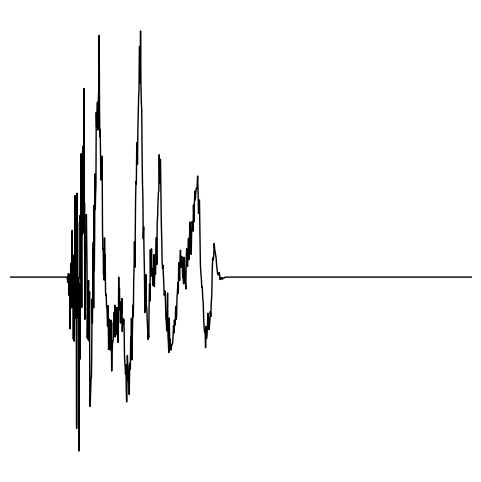

In [226]:
my_dpi = 100
fig, ax = plt.subplots(figsize=(6,6), dpi=my_dpi)
ax.plot(wavelength, main_wavelength.iloc[:, 800], lw=1.0, ls='-', color='k', alpha=1)
ax.axis('off')
ax.set_box_aspect(1)
ax.set_xlim(2500, 10000)
#ax.set_ylim(0,1)
plt.show()